In [1]:
from jax.config import config

config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import jit
from jax.config import config
import jax.numpy as jnp
#from jax.lax import erf
from jax.scipy.special import erf
import jax.random as jr
from typing import List, Union, Callable
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from jax import vmap
from gpjax.kernels import ProductKernel
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.mcmc import sample_halton_sequence 
from matplotlib import rcParams
from gpjax.base import param_field, static_field
import matplotlib.pyplot as plt
import optax as ox
import pandas as pd
import jaxopt
import tensorflow_probability as tfp
from jaxtyping import Float, Num
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(12345)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


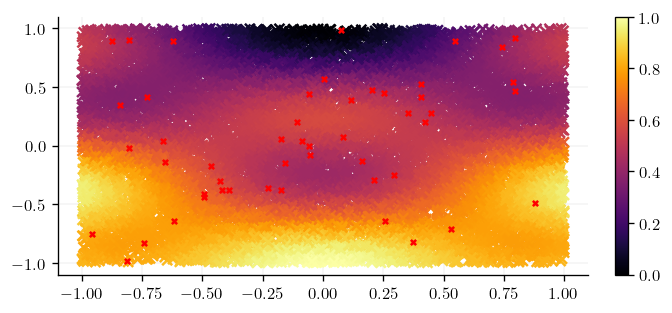

In [2]:
n = 50
d=2
noise = jnp.sqrt(0.01)
# key, subkey = jr.split(key)

def f(x):
    x_1 = x[:,0:1]
    x_2 = x[:,1:2]
    return (x_1**2 - 2*x_2 + jnp.cos(3*x_1)*jnp.sin(5*x_2))


#x = jr.normal(key=key, shape=(n,d)) * 0.5
x = jr.uniform(key=key, shape=(n,d), minval=-1.0, maxval=1.0)   
#x = (sample_halton_sequence(dim=d, num_results=n, seed=key) - 0.5)*2
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

n_plot = 10_000
xplot = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_plot,d))
yplot = f(xplot)
plt.scatter(xplot[:,0], xplot[:,1], c=yplot)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

n_test = 1_000
xtest = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_test,d))


In [4]:

@dataclass
class ConstantKernel(gpx.kernels.AbstractKernel):
    variance: ScalarFloat = param_field(1.0, bijector=tfb.Softplus())

    def __call__(self, x, y):
        return self.variance




@dataclass()
class OLDOrthogonalAdditiveKernel(gpx.kernels.AbstractKernel): 
    base_kernel: RBFOrthogonalKernel =  RBFOrthogonalKernel()
    max_interaction_depth: ScalarInt = static_field(1)
    interaction_variances: Num[Array, " p"] = param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus()) # for constant term   

    def __post_init__(self):
        assert self.max_interaction_depth == len(self.interaction_variances)-1


    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF OAK kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        #x = self.slice_input(x) # [d]
        #y = self.slice_input(y) # [d]
        ks = self.base_kernel._eval_sub_kernels(x, y) # [d]
        return jnp.dot(self.compute_additive_terms_girad_newton(ks), self.interaction_variances)

       
    @jit   
    def compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """
        assert self.max_interaction_depth in [1,2]
        if self.max_interaction_depth == 1:
            e = [1, ks[0]+ks[1]]
        else:
            e = [1, ks[0]+ks[1], ks[0]*ks[1]]
        # ks = ks[None, :] # [1, d]
        # powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        # s = jnp.power(ks,powers) # [p+1, d]
        # e = jnp.zeros(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        # e = e.at[0].set(1.0) # start with constant term
        # for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
        #     thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
        #     e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    

    def return_specific_contribution(self, iComponent_list: List[int] = [0]) -> gpx.kernels.AbstractKernel:
        
        kernel = ConstantKernel(variance = self.interaction_variances[len(iComponent_list)])

        if len(iComponent_list)>0:
            sliced_lengthscale = self.base_kernel.lengthscale[..., iComponent_list] if self.base_kernel.lengthscale.ndim > 0 else self.base_kernel.lengthscale
            kernel *=RBFOrthogonalKernel(active_dims=iComponent_list, lengthscale=sliced_lengthscale)
        
        return kernel



@dataclass
class RBFOrthogonalKernel(gpx.kernels.AbstractKernel):
    lengthscale: Float[Array, " D"] = param_field(
        jnp.array(1.0), bijector=tfb.SoftClip(low=1e-3, high=1e3)
    )
    input_measure: tfd.Distribution= static_field(tfd.Normal(loc=0.0, scale=1.0))

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        return jnp.prod(self._eval_sub_kernels(x, y))
      
    def _eval_sub_kernels(self,x: Num[Array, " D"], y: Num[Array, " D"] ) -> Num[Array, " D"]:
        x = (x) / self.lengthscale # [d]
        y = (y) / self.lengthscale # [d]
        dists = (x - y) ** 2  # [d]
        ks = jnp.exp(-0.5 * dists) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return ks # [d]
    
    def _cov_x_s(self,x):
        l = self.lengthscale
        mean, var = self.input_measure.loc, self.input_measure.scale**2
        return var * jnp.sqrt(l**2 / (l**2 + var)) * jnp.exp(-0.5 * ((x - mean) ** 2) / (l**2 + var)) # [d]

    def _var_s(self):
        l = self.lengthscale
        mean, var = self.input_measure.loc, self.input_measure.scale**2
        return var * jnp.sqrt(l**2 / (l**2 + 2.0*var))# [d]





  0%|          | 0/100 [00:00<?, ?it/s]

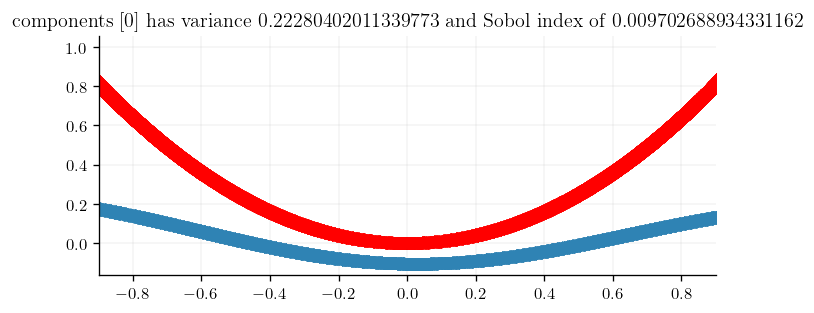

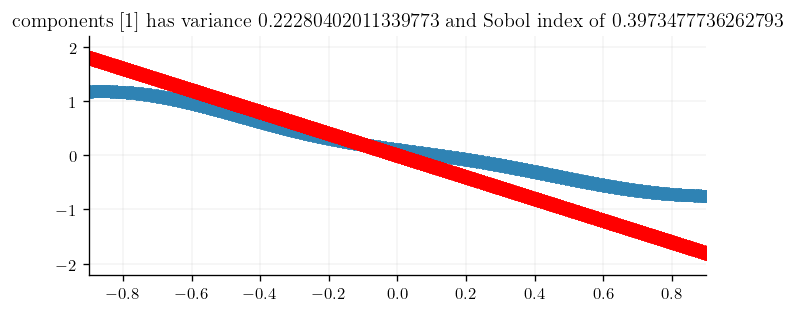

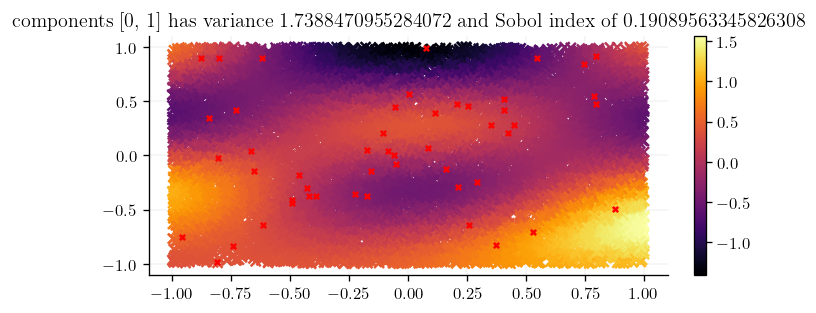

In [11]:
kernel =  OLDOrthogonalAdditiveKernel( 
    base_kernel=  RBFOrthogonalKernel(lengthscale=jnp.array([0.1, 0.1])).replace_bijector(lengthscale=tfb.SoftClip(jnp.array(1e-3, dtype=jnp.float64),jnp.array(1e3, dtype=jnp.float64))),
    max_interaction_depth = 2,
    interaction_variances = jnp.array([0.1, 0.1, 0.1]),
)


meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=noise).replace_trainable(obs_noise=False)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    #solver =jaxopt.ScipyMinimize(fun = ConjugateMLLWithGamma(negative=True)),
    solver=jaxopt.OptaxSolver(ConjugateMLLWithGamma(negative=True), opt=ox.adam(1e-1), maxiter=100),
    train_data=D,
    key=key,
)



def predict_from_specific_kernel(specific_kernel, posterior, D, xpred):
        x, y, n = D.X, D.y, D.n

        # Unpack test inputs
        t, n_test = xpred, xpred.shape[0]

        # Observation noise o²
        obs_noise = posterior.likelihood.obs_noise
        mx = posterior.prior.mean_function(x)

        # Precompute Gram matrix, Kxx, at training inputs, x
        Kxx = vmap(lambda a: vmap(lambda b: posterior.prior.kernel(a, b))(x))(x) 
        Kxx += (jnp.eye(n) * posterior.prior.jitter)

        # Σ = Kxx + Io²
  
        Sigma = Kxx + jnp.eye(n) * obs_noise

        mean_t = posterior.prior.mean_function(t)
        Kxt = vmap(lambda a: vmap(lambda b: specific_kernel(a, b))(x))(t) 
        # Σ⁻¹ Kxt
        Sigma_inv_Kxt = jnp.linalg.solve(Sigma, Kxt.T) # [n, t]
        # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
        return mean_t + jnp.matmul(Sigma_inv_Kxt.T, y - mx) # [t, 1]



def plot_posterior_with_components(kernel, components):
    overal_mean_on_training = opt_posterior.predict(D.X, D).mean()
    if len(components)>2 or len(components)==0:
        raise ValueError("Can only plot 1D or 2D")
    specific_kernel =  kernel.return_specific_contribution(components)
    mean =  predict_from_specific_kernel(specific_kernel, opt_posterior, D, xplot)
    specific_mean_on_training =predict_from_specific_kernel(specific_kernel, opt_posterior, D, D.X)

    if len(components)==1:
        plt.figure()
        plt.scatter(xplot[:,components[0]], mean)
        if components[0]==0:
            plt.scatter(xplot[:,components[0]], xplot[:,components[0]]**2, color="red")
        else:
             plt.scatter(xplot[:,components[0]], -2*xplot[:,components[0]], color="red")
        plt.title(f"components {components} has variance {kernel.interaction_variances[len(components)]} and Sobol index of {jnp.var(specific_mean_on_training) / jnp.var(overal_mean_on_training)}")
        plt.xlim(-0.9,0.9)
        #plt.scatter(x[:,components[0]],y[:,0], color="red", s=10.0)
    elif len(components)==2:
        plt.figure()
        plt.scatter(xplot[:,0], xplot[:,1], c=mean)
        plt.title(f"components {components} has variance {kernel.interaction_variances[len(components)]} and Sobol index of {jnp.var(specific_mean_on_training) / jnp.var(overal_mean_on_training)}")
        plt.colorbar()
        plt.scatter(x[:,0], x[:,1], color="red", s=10.0)

plot_posterior_with_components(opt_posterior.prior.kernel, [0])
plot_posterior_with_components(opt_posterior.prior.kernel, [1])
plot_posterior_with_components(opt_posterior.prior.kernel, [0,1])